
# Next Product which can be Purchased Prediction


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Considering purchase_historyXcustomer_data

In [ ]:
# Step 1: Read the CSV files into pandas DataFrames
purchase_history_df = pd.read_csv('purchase_history.csv')
customer_data_df = pd.read_csv('customer_data.csv')

# Step 2: Merge the DataFrames based on the CustomerID attribute
df = pd.merge(purchase_history_df, customer_data_df, on='CustomerID')

# Step 3: Feature Engineering
# Convert PurchaseDate to datetime
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

## Making Considerable dataframes

In [3]:

# Calculate total amount spent by each customer
df['TotalSpent'] = df['Price'] * df['Quantity']

# Group by CustomerID to aggregate purchase history
customer_features = df.groupby('CustomerID').agg({
    'TotalSpent': 'sum',
    'Quantity': 'sum',
    'PurchaseDate': ['min', 'max', 'nunique'],
    'Product': lambda x: x.mode()[0]
}).reset_index()

# Flatten the column names
customer_features.columns = ['CustomerID', 'TotalSpent', 'TotalQuantity', 'FirstPurchase', 'LastPurchase', 'PurchaseFrequency', 'FavoriteProduct']

# Merge with customer data
df = pd.merge(customer_features, customer_data_df, on='CustomerID')

## Encode categorical features

In [4]:

label_encoders = {}
categorical_columns = ['FavoriteProduct', 'Gender']

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Convert datetime columns to Unix timestamps
df['FirstPurchase'] = pd.to_datetime(df['FirstPurchase']).apply(lambda x: x.timestamp())
df['LastPurchase'] = pd.to_datetime(df['LastPurchase']).apply(lambda x: x.timestamp())

## Select features and target

In [5]:


features = ['TotalSpent', 'TotalQuantity', 'FirstPurchase', 'LastPurchase', 'PurchaseFrequency', 'FavoriteProduct', 'Age', 'Gender']
X = df[features]
y = df['FavoriteProduct']  # Use FavoriteProduct as a proxy for what the customer might buy next

# Standardize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Devloping Predictive Model

In [6]:
# Step 5: Develop a predictive model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00         9

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



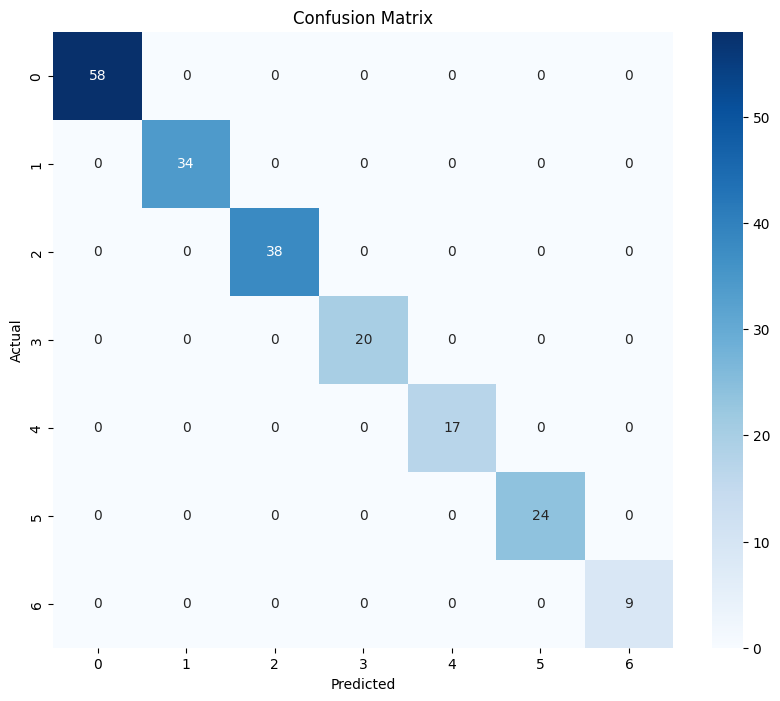

In [7]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## checking the generated model

In [8]:

# Function to predict and summarize next likely product
def predict_next_product(model, scaler, label_encoders, new_data):
    new_data_df = pd.DataFrame([new_data])
    
    # Encode categorical data
    for column in categorical_columns:
        if column in new_data_df.columns:
            le = label_encoders[column]
            new_data_df[column] = le.transform(new_data_df[column])
    
    # Convert datetime columns to Unix timestamps
    if 'FirstPurchase' in new_data_df.columns:
        new_data_df['FirstPurchase'] = pd.to_datetime(new_data_df['FirstPurchase']).apply(lambda x: x.timestamp())
    if 'LastPurchase' in new_data_df.columns:
        new_data_df['LastPurchase'] = pd.to_datetime(new_data_df['LastPurchase']).apply(lambda x: x.timestamp())
    
    # Standardize numerical features
    new_data_df[features] = scaler.transform(new_data_df[features])
    
    # Predict the next product
    prediction = model.predict(new_data_df[features])[0]
    product = label_encoders['FavoriteProduct'].inverse_transform([prediction])[0]
    
    # Display the result
    print("Predicted Next Product:", product)
    print("Details of the input data:")
    for key, value in new_data.items():
        print(f"{key}: {value}")


## Random value feeding

In [9]:
# Test the function with some random data
new_data = {
    'TotalSpent': 1500,
    'TotalQuantity': 10,
    'FirstPurchase': '2023-01-01',
    'LastPurchase': '2024-01-01',
    'PurchaseFrequency': 10,
    'FavoriteProduct': 'Laptop',
    'Age': 35,
    'Gender': 'Male'
}

predict_next_product(model, scaler, label_encoders, new_data)

Predicted Next Product: Laptop
Details of the input data:
TotalSpent: 1500
TotalQuantity: 10
FirstPurchase: 2023-01-01
LastPurchase: 2024-01-01
PurchaseFrequency: 10
FavoriteProduct: Laptop
Age: 35
Gender: Male


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


## As we got 100% accuracy which is Quite Unsual This may be Due to faker generated dataset

### Cross-Validation:

Added cross-validation using cross_val_score to evaluate the model’s performance on different subsets of the data.
This helps to ensure the model generalizes well and is not overfitting.
### Check for Data Leakage:

Ensure features are correctly processed and split.


### The code prints cross-validation scores and their mean, which provides a more robust estimate of model performance.

In [12]:


# Cross-Validation to check for overfitting
cv_scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Score: {cv_scores.mean()}')

# Function to predict and summarize next likely product
def predict_next_product(model, scaler, label_encoders, new_data):
    new_data_df = pd.DataFrame([new_data])
    
    # Encode categorical data
    for column in categorical_columns:
        if column in new_data_df.columns:
            le = label_encoders[column]
            new_data_df[column] = le.transform(new_data_df[column])
    
    # Convert datetime columns to Unix timestamps
    if 'FirstPurchase' in new_data_df.columns:
        new_data_df['FirstPurchase'] = pd.to_datetime(new_data_df['FirstPurchase']).apply(lambda x: x.timestamp())
    if 'LastPurchase' in new_data_df.columns:
        new_data_df['LastPurchase'] = pd.to_datetime(new_data_df['LastPurchase']).apply(lambda x: x.timestamp())
    
    # Standardize numerical features
    new_data_df[features] = scaler.transform(new_data_df[features])
    
    # Predict the next product
    prediction = model.predict(new_data_df[features])[0]
    product = label_encoders['FavoriteProduct'].inverse_transform([prediction])[0]
    
    # Display the result
    print("Predicted Next Product:", product)
    print("Details of the input data:")
    for key, value in new_data.items():
        print(f"{key}: {value}")

# Test the function with some random data
new_data = {
    'TotalSpent': 1500,
    'TotalQuantity': 10,
    'FirstPurchase': '2023-01-01',
    'LastPurchase': '2024-01-01',
    'PurchaseFrequency': 10,
    'FavoriteProduct': 'Laptop',
    'Age': 35,
    'Gender': 'Male'
}

predict_next_product(model, scaler, label_encoders, new_data)


Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean Cross-Validation Score: 1.0
Predicted Next Product: Laptop
Details of the input data:
TotalSpent: 1500
TotalQuantity: 10
FirstPurchase: 2023-01-01
LastPurchase: 2024-01-01
PurchaseFrequency: 10
FavoriteProduct: Laptop
Age: 35
Gender: Male


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
